<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week45.do.txt --no_mako -->
<!-- dom:TITLE: Week 45,  Recurrent Neural Networks -->

# Week 45,  Recurrent Neural Networks
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **November 6-10**

## Plan for week 45

**Material for the active learning sessions on Tuesday and Wednesday.**

  * Discussion of project 2

  * [Video of lab session from week 43](https://youtu.be/Ia6wwDLxqtM)

  * [Video of lab session from week 44](https://youtu.be/EajWMW__k0I)

  * [See also whiteboard notes from lab session week 44](https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/2023/Exercisesweek44.pdf)

  

**Material for the lecture on Thursday November 9, 2023.**

  * Short repetition on Convolutional Neural Networks

  * Recurrent  Neural Networks (RNNs)

  * Readings and Videos:

    * These lecture notes

    * For a more in depth discussion on  neural networks we recommend Goodfellow et al chapter 10. See also chapter 11 and 12 on practicalities and applications    

     * Reading suggestions for implementation of RNNs: [Aurelien Geron's chapter 14](https://github.com/CompPhysics/MachineLearning/blob/master/doc/Textbooks/TensorflowML.pdf).

    * [Video  on Recurrent Neural Networks from MIT](https://www.youtube.com/watch?v=SEnXr6v2ifU&ab_channel=AlexanderAmini)

    * [Video on Deep Learning](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

## Material for the lab sessions, additional ways to present classification results and other practicalities

## Searching for Optimal Regularization Parameters $\lambda$

In project 1, when using Ridge and Lasso regression, we end up
searching for the optimal parameter $\lambda$ which minimizes our
selected scores (MSE or $R2$ values for example). The brute force
approach, as discussed in the code here for Ridge regression, consists
in evaluating the MSE as function of different $\lambda$ values.
Based on these calculations, one tries then to determine the value of the hyperparameter $\lambda$
which results in optimal scores (for example the smallest MSE or an $R2=1$).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use
nlambdas = 500
MSERidgePredict = np.zeros(nlambdas)
lambdas = np.logspace(-4, 2, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    RegRidge = linear_model.Ridge(lmb)
    RegRidge.fit(X_train,y_train)
    ypredictRidge = RegRidge.predict(X_test)
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)

# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSERidgePredict, 'g--', label = 'MSE SL Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

Here we have performed a rather data greedy calculation as function of the regularization parameter $\lambda$. There is no resampling here. The latter can easily be added by employing the function **RidgeCV** instead of just calling the **Ridge** function. For **RidgeCV** we need to pass the array of $\lambda$ values.
By inspecting the figure we can in turn determine which is the optimal regularization parameter.
This becomes however less functional in the long run.

## Grid Search

An alternative is to use the so-called grid search functionality
included with the library **Scikit-Learn**, as demonstrated for the same
example here.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Decide which values of lambda to use
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas)
# create and fit a ridge regression model, testing each alpha
model = Ridge()
gridsearch = GridSearchCV(estimator=model, param_grid=dict(alpha=lambdas))
gridsearch.fit(X_train, y_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(y_test,ypredictRidge)}")
print(f"R2 score: {R2(y_test,ypredictRidge)}")

By default the grid search function includes cross validation with
five folds. The [Scikit-Learn
documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
contains more information on how to set the different parameters.

If we take out the random noise, running the above codes results in $\lambda=0$ yielding the best fit.

## Randomized Grid Search

An alternative to the above manual grid set up, is to use a random
search where the parameters are tuned from a random distribution
(uniform below) for a fixed number of iterations. A model is
constructed and evaluated for each combination of chosen parameters.
We repeat the previous example but now with a random search.  Note
that values of $\lambda$ are now limited to be within $x\in
[0,1]$. This domain may not be the most relevant one for the specific
case under study.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform as randuniform
from sklearn.model_selection import RandomizedSearchCV


def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(2021)

n = 100
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((n,Maxpolydegree-1))

for degree in range(1,Maxpolydegree): #No intercept column
    X[:,degree-1] = x**(degree)

# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {'alpha': randuniform()}
# create and fit a ridge regression model, testing each alpha
model = Ridge()
gridsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
gridsearch.fit(X_train, y_train)
print(gridsearch)
ypredictRidge = gridsearch.predict(X_test)
# summarize the results of the grid search
print(f"Best estimated lambda-value: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(y_test,ypredictRidge)}")
print(f"R2 score: {R2(y_test,ypredictRidge)}")

## Wisconsin Cancer Data

We show here how we can use a simple regression case on the breast
cancer data using Logistic regression as our algorithm for
classification.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))

## Using the correlation matrix

In addition to the above scores, we could also study the covariance (and the correlation matrix).
We use **Pandas** to compute the correlation matrix.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()
import pandas as pd
# Making a data frame
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()

import seaborn as sns
correlation_matrix = cancerpd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

## Discussing the correlation data

In the above example we note two things. In the first plot we display
the overlap of benign and malignant tumors as functions of the various
features in the Wisconsing breast cancer data set. We see that for
some of the features we can distinguish clearly the benign and
malignant cases while for other features we cannot. This can point to
us which features may be of greater interest when we wish to classify
a benign or not benign tumour.

In the second figure we have computed the so-called correlation
matrix, which in our case with thirty features becomes a $30\times 30$
matrix.

We constructed this matrix using **pandas** via the statements

In [6]:
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

and then

In [7]:
correlation_matrix = cancerpd.corr().round(1)

Diagonalizing this matrix we can in turn say something about which
features are of relevance and which are not. This leads  us to
the classical Principal Component Analysis (PCA) theorem with
applications. This will be discussed later this semester ([week 43](https://compphysics.github.io/MachineLearning/doc/pub/week43/html/week43-bs.html)).

## Other ways of presenting a classification problem

For a binary classifcation matrix, the so-called **confusion matrix**, is often used. It can also be extended to more catgeories/classes as well.
The following quantities are then used
1. positive condition number $P$, which represents the number of real positive cases in the data (output one/true etc)

2. The condition negative number $N$ which is the number of negative cases (ouput zero/false etc)

3. The true positive number $TP$ which represents whether a positive test result has been correctly classified (the application of our trained model on a test data set)

4. The true negative $TN$ number which represents whether a negative test has been correctly classified

5. The false positive $FP$ number, a so-called type I error which tells us about the fraction of  positive test result which are wrongly classified

6. A false negative $FN$ number, a so-called type II error which, should be pretty obvious, indicates if a negative test has been wrongly classified.

It is is easy to think in terms of illness. You could think of the above as
1. True positive: Sick people correctly identified as sick

2. False positive: Healthy people incorrectly identified as sick

3. True negative: Healthy people correctly identified as healthy

4. False negative: Sick people incorrectly identified as healthy

## Combinations of classification results

It is common in the literature to define various combinations the above numbers. The most commonly used are

**Sensitivity, recall, hit rate, or true positive rate $TPR$. It is the probability of a positive test result, conditioned on the individual truly being positive.**

$$
{\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} }
$$

The $TPR$ defines how many correct positive results occur among all positive samples available during the test

**Miss rate or false negative rate $FNR$.**

$$
{\displaystyle \mathrm {FNR} ={\frac {\mathrm {FN} }{\mathrm {P} }}={\frac {\mathrm {FN} }{\mathrm {FN} +\mathrm {TP} }} }
$$

**Specificity, selectivity or true negative rate $TNR$. It is the probability of a negative test result, conditioned on the individual truly being negative.**

$$
{\displaystyle \mathrm {TNR} ={\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}=1-\mathrm {FPR} }
$$

with the fall-out false positive rate

$$
{\displaystyle \mathrm {FPR} ={\frac {\mathrm {FP} }{\mathrm {N} }}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR} }
$$

The $FPR$ defines how many incorrect positive results occur among
all negative samples available during the test.

## Positive and negative prediction values

The positive and negative predictive values 
are the proportions of positive and negative results in statistics and
diagnostic tests that are true positive and true negative results,
respectively.[1] The PPV and NPV describe the performance of a
diagnostic test or other statistical measure. A high result can be
interpreted as indicating the accuracy of such a statistic.

**Precision or positive predictive value $PPV$.**

$$
{\displaystyle \mathrm {PPV} ={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}=1-\mathrm {FDR} }
$$

**Negative predictive value $NPV$.**

$$
{\displaystyle \mathrm {NPV} ={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FN} }}=1-\mathrm {FOR} }
$$

## Other quantities

**False discovery rate $FDR$.**

$$
{\displaystyle \mathrm {FDR} ={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TP} }}=1-\mathrm {PPV} }
$$

**False omission rate $FOR$.**

$$
{\displaystyle \mathrm {FOR} ={\frac {\mathrm {FN} }{\mathrm {FN} +\mathrm {TN} }}=1-\mathrm {NPV} }
$$

## $F_1$ score

In statistical analysis of binary classification, the F-score or
F-measure is a measure of a test's accuracy. It is calculated from the
precision and recall of the test, where the precision is the number of
true positive results divided by the number of all positive results,
including those not identified correctly, and the recall is the number
of true positive results divided by the number of all samples that
should have been identified as positive. Precision is also known as
positive predictive value, and recall is also known as sensitivity in
diagnostic binary classification.

The F1 score is the harmonic mean of the precision and recall. It thus
symmetrically represents both precision and recall in one metric.  The
highest possible value of an F-score is 1.0, indicating perfect
precision and recall, and the lowest possible value is 0, if either
precision or recall are zero.

It is defined as

$$
{\displaystyle \mathrm {F} _{1}=2\times {\frac {\mathrm {PPV} \times \mathrm {TPR} }{\mathrm {PPV} +\mathrm {TPR} }}={\frac {2\mathrm {TP} }{2\mathrm {TP} +\mathrm {FP} +\mathrm {FN} }}}
$$

## ROC curve

A receiver operating characteristic curve, or ROC curve, is a
graphical plot that illustrates the performance of a binary classifier
model at varying threshold values.

The ROC curve is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting.

To draw a ROC curve, only the true positive rate (TPR) and false
positive rate (FPR) are needed (as functions of some classifier
parameter). The TPR defines how many correct positive results occur
among all positive samples available during the test. FPR, on the
other hand, defines how many incorrect positive results occur among
all negative samples available during the test.

See <https://en.wikipedia.org/wiki/Receiver_operating_characteristic> for more discussions.

## Cumulative gain curve

The cumulative gain curve is a performance evaluation used typically for binary classification problems.
It plots the $TPR$ True Positive Rate or Sensitivity (which represents the 
fraction of examples correctly classified
against Predictive Positive Rate, which represents 
the fraction of positively predicted examples.

The examples below show the confusion matrix (or error matrix), the ROC curve and the cumulative gain for the Wisconsin cancer data.

## Other measures in classification studies: Cancer Data  again

(426, 30)
(143, 30)
[1.         0.86666667 1.         0.92857143 1.         0.85714286
 1.         0.92857143 0.92857143 1.        ]
Test set accuracy with Logistic Regression: 0.94


/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mhjensen/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

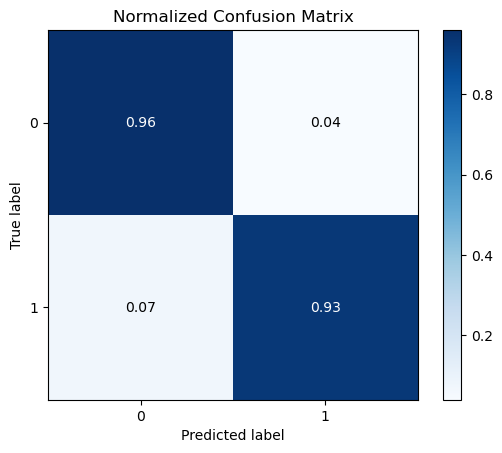

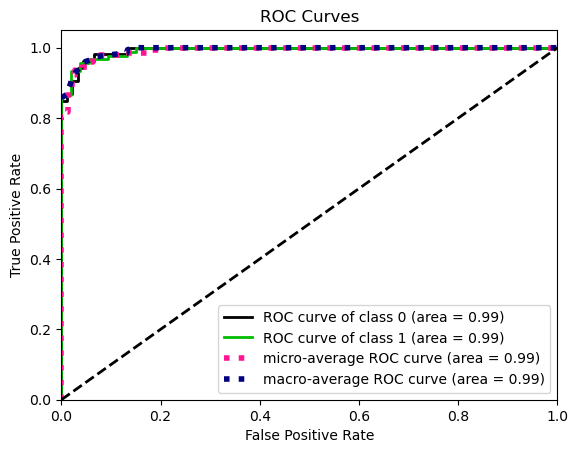

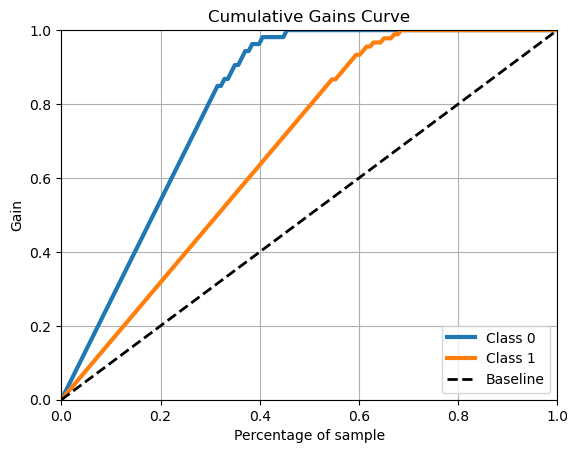

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
#Cross validation
accuracy = cross_validate(logreg,X_test,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))

import scikitplot as skplt
y_pred = logreg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = logreg.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

## Material for Lecture Thursday November 9

## Recurrent neural networks (RNNs): Overarching view

Till now our focus has been, including convolutional neural networks
as well, on feedforward neural networks. The output or the activations
flow only in one direction, from the input layer to the output layer.

A recurrent neural network (RNN) looks very much like a feedforward
neural network, except that it also has connections pointing
backward. 

RNNs are used to analyze time series data such as stock prices, and
tell you when to buy or sell. In autonomous driving systems, they can
anticipate car trajectories and help avoid accidents. More generally,
they can work on sequences of arbitrary lengths, rather than on
fixed-sized inputs like all the nets we have discussed so far. For
example, they can take sentences, documents, or audio samples as
input, making them extremely useful for natural language processing
systems such as automatic translation and speech-to-text.

## A simple example

In [9]:
# Start importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras import optimizers     
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical 



# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)
plt.plot(df)
plt.plot(predicted)
plt.show()

### RNNs

RNNs are very powerful, because they
combine two properties:
1. Distributed hidden state that allows them to store a lot of information about the past efficiently.

2. Non-linear dynamics that allows them to update their hidden state in complicated ways.

With enough neurons and time, RNNs
can compute anything that can be
computed by your computer!

## Basic layout

<!-- dom:FIGURE: [figslides/RNN1.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN1.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

### We need to specify the initial activity state of all the hidden and output units

1. We could just fix these initial states to have some default value like 0.5.

2. But it is better to treat the initial states as learned parameters.

3. We learn them in the same way as we learn the weights.

* Start off with an initial random guess for the initial states.

a. At the end of each training sequence, backpropagate through time all the way to the initial states to get the gradient of the error function with respect to each initial state.

b. Adjust the initial states by following the negative gradient.

### We can specify inputs in several ways

1. Specify the initial states of all the units.

2. Specify the initial states of a subset of the units.

3. Specify the states of the same subset of the units at every time step.

This is the natural way to model most sequential data.

### We can specify targets in several ways

1. Specify desired final activities of all the units

2. Specify desired activities of all units for the last few steps

* Good for learning attractors

* It is easy to add in extra error derivatives as we backpropagate.

  * Specify the desired activity of a subset of the units.

* The other units are input or hidden units. 

<!-- dom:FIGURE: [figslides/RNN2.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN2.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN3.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN3.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN4.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN4.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN5.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN5.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

### Backpropagation through time

We can think of the recurrent net as a layered, feed-forward
net with shared weights and then train the feed-forward net
with weight constraints.

We can also think of this training algorithm in the time domain:
1. The forward pass builds up a stack of the activities of all the units at each time step.

2. The backward pass peels activities off the stack to compute the error derivatives at each time step.

3. After the backward pass we add together the derivatives at all the different times for each weight.

### The backward pass is linear

1. There is a big difference between the forward and backward passes.

2. In the forward pass we use squashing functions (like the logistic) to prevent the activity vectors from exploding.

3. The backward pass, is completely linear. If you double the error derivatives at the final layer, all the error derivatives will double.

The forward pass determines the slope of the linear function used for
backpropagating through each neuron

<!-- dom:FIGURE: [figslides/RNN6.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN6.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN7.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN7.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN8.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN8.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN9.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN9.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN10.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN10.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN11.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN11.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN12.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN12.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## The problem of exploding or vanishing gradients
* What happens to the magnitude of the gradients as we backpropagate through many layers?

a. If the weights are small, the gradients shrink exponentially.

b. If the weights are big the gradients grow exponentially.

* Typical feed-forward neural nets can cope with these exponential effects because they only have a few hidden layers.

* In an RNN trained on long sequences (e.g. 100 time steps) the gradients can easily explode or vanish.

a. We can avoid this by initializing the weights very carefully.

* Even with good initial weights, its very hard to detect that the current target output depends on an input from many time-steps ago.

RNNs have difficulty dealing with long-range dependencies.

## Four effective ways to learn an RNN
1. Long Short Term Memory Make the RNN out of little modules that are designed to remember values for a long time.

2. Hessian Free Optimization: Deal with the vanishing gradients problem by using a fancy optimizer that can detect directions with a tiny gradient but even smaller curvature.

3. Echo State Networks: Initialize the input a hidden and hidden-hidden and output-hidden connections very carefully so that the hidden state has a huge reservoir of weakly coupled oscillators which can be selectively driven by the input.

  * ESNs only need to learn the hidden-output connections.

4. Good initialization with momentum Initialize like in Echo State Networks, but then learn all of the connections using momentum

### Long Short Term Memory (LSTM)

LSTM uses a memory cell for 
 modeling long-range dependencies and avoid vanishing gradient
 problems.

1. Introduced by Hochreiter and Schmidhuber (1997) who solved the problem of getting an RNN to remember things for a long time (like hundreds of time steps).

2. They designed a memory cell using logistic and linear units with multiplicative interactions.

3. Information gets into the cell whenever its “write” gate is on.

4. The information stays in the cell so long as its **keep** gate is on.

5. Information can be read from the cell by turning on its **read** gate.

### Implementing a memory cell in a neural network

To preserve information for a long time in
the activities of an RNN, we use a circuit
that implements an analog memory cell.

1. A linear unit that has a self-link with a weight of 1 will maintain its state.

2. Information is stored in the cell by activating its write gate.

3. Information is retrieved by activating the read gate.

4. We can backpropagate through this circuit because logistics are have nice derivatives. 

<!-- dom:FIGURE: [figslides/RNN13.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN13.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN14.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN14.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN15.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN15.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN16.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN16.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN17.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN17.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN18.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN18.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN19.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN19.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN20.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN20.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN21.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN21.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

<!-- dom:FIGURE: [figslides/RNN22.png, width=700 frac=0.9] -->
<!-- begin figure -->

<img src="figslides/RNN22.png" width="700"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## An extrapolation example

The following code provides an example of how recurrent neural
networks can be used to extrapolate to unknown values of physics data
sets.  Specifically, the data sets used in this program come from
a quantum mechanical many-body calculation of energies as functions of the number of particles.

In [10]:

# For matrices and calculations
import numpy as np
# For machine learning (backend for keras)
import tensorflow as tf
# User-friendly machine learning library
# Front end for TensorFlow
import tensorflow.keras
# Different methods from Keras needed to create an RNN
# This is not necessary but it shortened function calls 
# that need to be used in the code.
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
# For timing the code
from timeit import default_timer as timer
# For plotting
import matplotlib.pyplot as plt


# The data set
datatype='VaryDimension'
X_tot = np.arange(2, 42, 2)
y_tot = np.array([-0.03077640549, -0.08336233266, -0.1446729567, -0.2116753732, -0.2830637392, -0.3581341341, -0.436462435, -0.5177783846,
	-0.6019067271, -0.6887363571, -0.7782028952, -0.8702784034, -0.9649652536, -1.062292565, -1.16231451, 
	-1.265109911, -1.370782966, -1.479465113, -1.591317992, -1.70653767])

## Formatting the Data

The way the recurrent neural networks are trained in this program
differs from how machine learning algorithms are usually trained.
Typically a machine learning algorithm is trained by learning the
relationship between the x data and the y data.  In this program, the
recurrent neural network will be trained to recognize the relationship
in a sequence of y values.  This is type of data formatting is
typically used time series forcasting, but it can also be used in any
extrapolation (time series forecasting is just a specific type of
extrapolation along the time axis).  This method of data formatting
does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the
form of (x,y) so the machine learning algorithm learns to assiciate a
y value with a given x value.  This is useful when the test data has x
values within the same range as the training data.  However, for this
application, the x values of the test data are outside of the x values
of the training data and the traditional method of training a machine
learning algorithm does not work as well.  For this reason, the
recurrent neural network is trained on sequences of y values of the
form ((y1, y2), y3), so that the network is concerned with learning
the pattern of the y data and not the relation between the x and y
data.  As long as the pattern of y data outside of the training region
stays relatively stable compared to what was inside the training
region, this method of training can produce accurate extrapolations to
y values far removed from the training data set.

<!--  -->
<!-- The idea behind formatting the data in this way comes from [this resource](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [this one](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html). -->
<!--  -->
<!-- The following method takes in a y data set and formats it so the "x data" are of the form (y1, y2) and the "y data" are of the form y3, with extra brackets added in to make the resulting arrays compatable with both Keras and Tensorflow. -->
<!--  -->
<!-- Note: Using a sequence length of two is not required for time series forecasting so any lenght of sequence could be used (for example instead of ((y1, y2) y3) you could change the length of sequence to be 4 and the resulting data points would have the form ((y1, y2, y3, y4), y5)).  While the following method can be used to create a data set of any sequence length, the remainder of the code expects the length of sequence to be 2.  This is because the data sets are very small and the higher the lenght of the sequence the less resulting data points. -->

In [11]:
# FORMAT_DATA
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output


# ## Defining the Recurrent Neural Network Using Keras
# 
# The following method defines a simple recurrent neural network in keras consisting of one input layer, one hidden layer, and one output layer.

def rnn(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 200
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

## Predicting New Points With A Trained Recurrent Neural Network

In [12]:
def test_rnn (x1, y_test, plot_min, plot_max):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y_test (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    y_pred = y_test[:dim].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[[y_test[dim-2]], [y_test[dim-1]]]])
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[dim-1]]

    # Iterate until the complete data set is created.
    for i in range (dim, len(y_test)):
        # Predict the next point in the data set using the previous two points.
        next = model.predict(next_input)
        # Append just the number of the predicted data set
        y_pred.append(next[0][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next

    # Print the mean squared error between the known data set and the predicted data set.
    print('MSE: ', np.square(np.subtract(y_test, y_pred)).mean())
    # Save the predicted data set as a csv file for later use
    name = datatype + 'Predicted'+str(dim)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.
    fig, ax = plt.subplots()
    ax.plot(x1, y_test, label="true", linewidth=3)
    ax.plot(x1, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Created a red region to represent the points used in the training data.
    ax.axvspan(plot_min, plot_max, alpha=0.25, color='red')
    plt.show()

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn(length_of_sequences = rnn_input.shape[1])
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Things to Try

Changing the size of the recurrent neural network and its parameters
can drastically change the results you get from the model.  The below
code takes the simple recurrent neural network from above and adds a
second hidden layer, changes the number of neurons in the hidden
layer, and explicitly declares the activation function of the hidden
layers to be a sigmoid function.  The loss function and optimizer can
also be changed but are kept the same as the above network.  These
parameters can be tuned to provide the optimal result from the
network.  For some ideas on how to improve the performance of a
[recurrent neural network](https://danijar.com/tips-for-training-recurrent-neural-networks).

In [13]:
def rnn_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two hidden layers and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer, increased from the first network
    hidden_neurons = 500
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Create two hidden layers instead of one hidden layer.  Explicitly set the activation
    # function to be the sigmoid function (the default value is hyperbolic tangent)
    rnn1 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,  # This needs to be True if another hidden layer is to follow
                    stateful = stateful, activation = 'sigmoid',
                    name="RNN1")(inp)
    rnn2 = SimpleRNN(hidden_neurons, 
                    return_sequences=False, activation = 'sigmoid',
                    stateful = stateful,
                    name="RNN2")(rnn1)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn2)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn_2layers(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Types of Recurrent Neural Networks

Besides a simple recurrent neural network layer, there are two other
commonly used types of recurrent neural network layers: Long Short
Term Memory (LSTM) and Gated Recurrent Unit (GRU).  For a short
introduction to these layers see <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>
and <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>.

The first network created below is similar to the previous network,
but it replaces the SimpleRNN layers with LSTM layers.  The second
network below has two hidden layers made up of GRUs, which are
preceeded by two dense (feeddorward) neural network layers.  These
dense layers "preprocess" the data before it reaches the recurrent
layers.  This architecture has been shown to improve the performance
of recurrent neural networks (see the link above and also
<https://arxiv.org/pdf/1807.02857.pdf>.

In [14]:
def lstm_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 250
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    rnn1 = LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN1", use_bias=True, activation='tanh')(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn1)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

def dnn2_gru2(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with four hidden layers (two dense followed by
        two GRU layers) and returns the model.
    """    
    # Number of neurons on the input/output layers and hidden layers
    in_out_neurons = 1
    hidden_neurons = 250
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden Dense (feedforward) layers
    dnn = Dense(hidden_neurons/2, activation='relu', name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation='relu', name='dnn1')(dnn)
    # Hidden GRU layers
    rnn1 = GRU(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN1", use_bias=True)(dnn1)
    rnn = GRU(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True)(rnn1)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the mdoel
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use
model = dnn2_gru2(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)


# ### Training Recurrent Neural Networks in the Standard Way (i.e. learning the relationship between the X and Y data)
# 
# Finally, comparing the performace of a recurrent neural network using the standard data formatting to the performance of the network with time sequence data formatting shows the benefit of this type of data formatting with extrapolation.

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Reshape the data for Keras specifications
X_train = X_train.reshape((dim, 1))
y_train = y_train.reshape((dim, 1))


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Set the sequence length to 1 for regular data formatting 
model = rnn(length_of_sequences = 1)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(X_train, y_train, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict the remaining data points
X_pred = X_tot[dim:]
X_pred = X_pred.reshape((len(X_pred), 1))
y_model = model.predict(X_pred)
y_pred = np.concatenate((y_tot[:dim], y_model.flatten()))

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()

# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)